# LOAD DATASET

In [1]:
import os

import pandas as pd
import numpy as np

from string import digits
from pyvi import ViTokenizer

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

import tensorflow as tf
import keras
from keras import regularizers
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input, Dense, Dropout, Reshape, Flatten, LSTM, SimpleRNN, concatenate
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import plot_model

2024-04-18 20:18:34.014191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 20:18:34.014505: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 20:18:34.017201: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 20:18:34.047391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 20:18:34.562013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


# TRAINING

### Preparation

In [3]:
labels_train = data_train.iloc[:, 0].values
reviews_train = data_train.iloc[:, 1].values

In [4]:
encoded_labels_train = []

for label_train in labels_train:
    if label_train == -1:
        encoded_labels_train.append([1,0,0])
    elif label_train == 0:
        encoded_labels_train.append([0,1,0])
    else:
        encoded_labels_train.append([0,0,1])

encoded_labels_train = np.array(encoded_labels_train)  

In [5]:
reviews_processed_train = []
for review_train in reviews_train:
    review_cool_one_train = ''.join([char for char in review_train if char not in digits])  # remove digits
    reviews_processed_train.append(review_cool_one_train)

In [6]:
#Use from pyvi import ViTokenizer for Vietnamese word tokenizer
word_reviews_train = []
for review_train in reviews_processed_train:
    review_train = ViTokenizer.tokenize(review_train.lower())
    word_reviews_train.append(review_train.split())

In [7]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [8]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews_train)
word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(word_reviews_train)

In [9]:
data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels_train = encoded_labels_train

In [10]:
print('Shape of X train tensor:',data_train.shape)
print('Shape of label train tensor:', labels_train.shape)

Shape of X train tensor: (5100, 300)
Shape of label train tensor: (5100, 3)


In [11]:
word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)

vocabulary_size=min(len(word_index)+1, MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            embeddings_initializer= keras.initializers.Constant(embedding_matrix),
                            trainable=True)

### CNN Model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 400)  │  3,167,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 298, 100)  │    120,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 297, 100)  │    160,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 296, 100)  │    200,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 100)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 100)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 100)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 100)    │          0 │ max_pooling1d[0]… │
│ (Concatenate)       │                   │            │ max_pooling1d_1[… │
│                     │                   │            │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 300)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300)       │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │        903 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,648,803 (13.92 MB)

 Trainable params: 3,648,803 (13.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4267 - loss: 7.4976
Epoch 1: val_loss improved from inf to 9.89307, saving model to weights/model_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4293 - loss: 7.4664 - val_accuracy: 9.8039e-04 - val_loss: 9.8931
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6920 - loss: 5.3311
Epoch 2: val_loss improved from 9.89307 to 6.26256, saving model to weights/model_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6923 - loss: 5.3198 - val_accuracy: 0.1765 - val_loss: 6.2626
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7808 - loss: 4.4907
Epoch 3: val_loss did not improve from 6.26256
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7815 - loss: 4.4830 - val_accuracy: 0.0784 - val_loss: 6.4246
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8615 - loss: 3.8569
Epoch 4: val_loss improved from 6.26256 to 5.77897, saving model to weights/model_cnn.keras


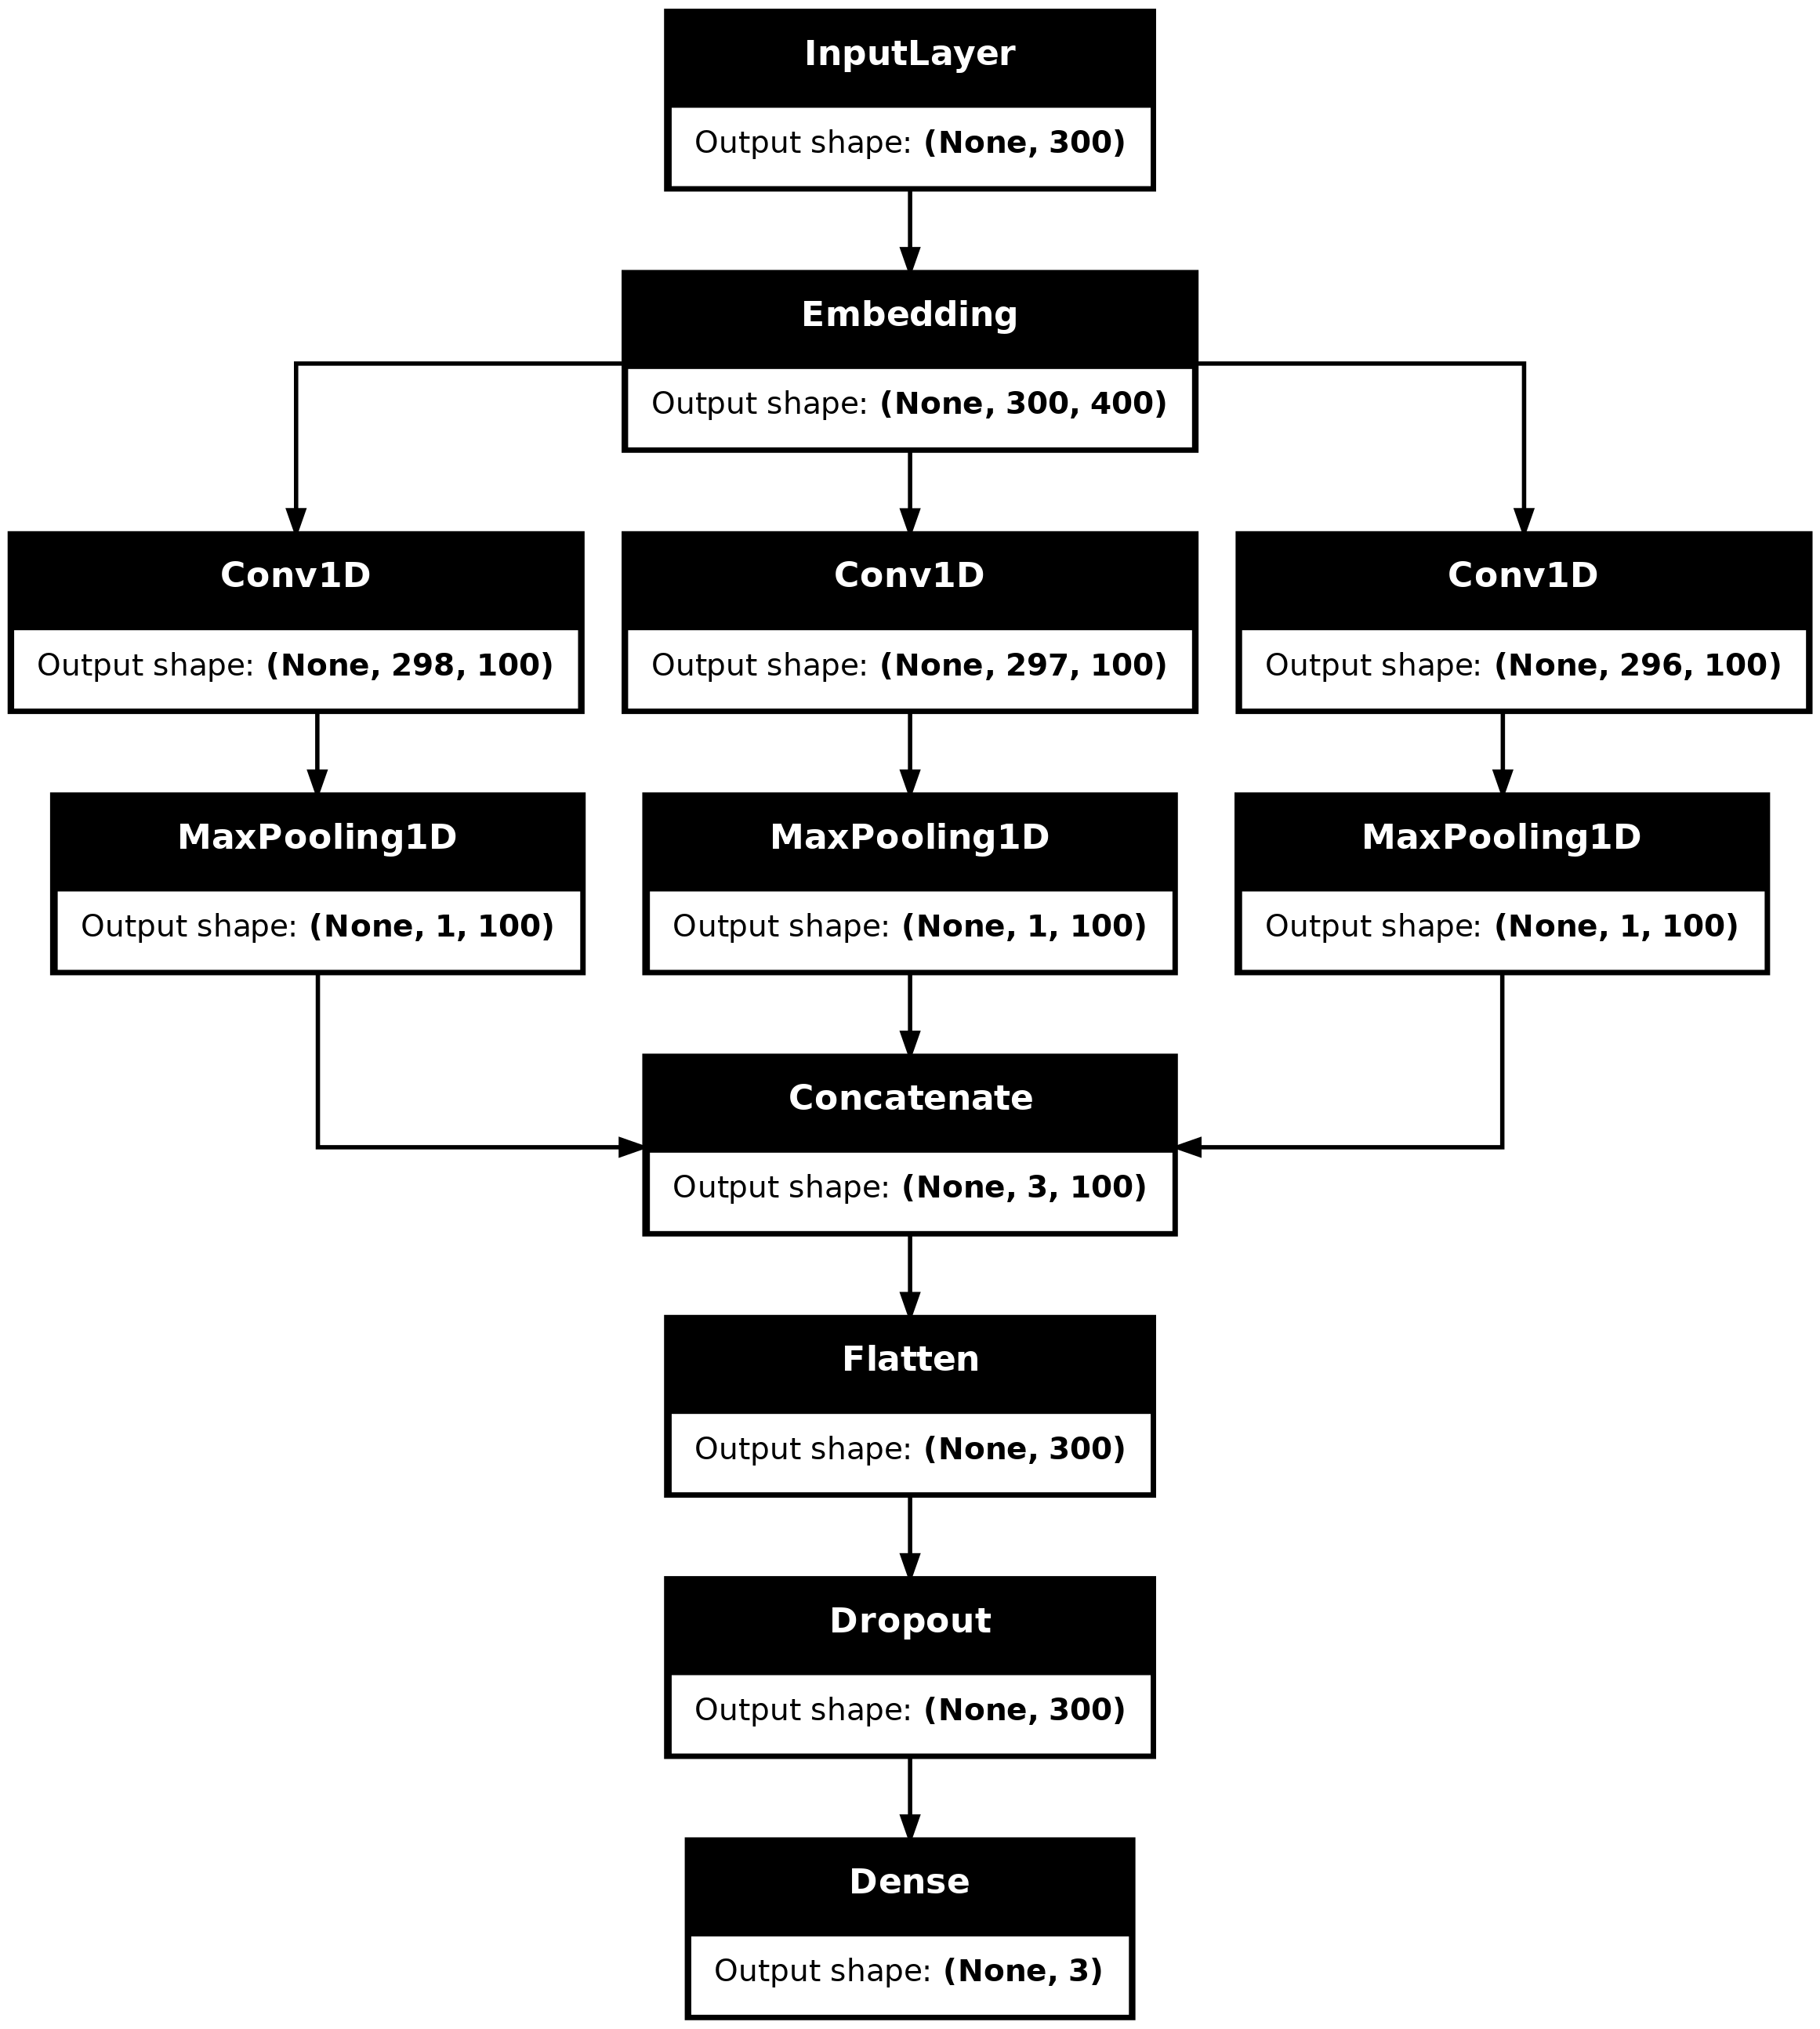

In [12]:
sequence_length = data_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.2

if os.path.exists('weights/model_cnn.keras'):
    model_cnn = keras.models.load_model('weights/model_cnn.keras')
else:

    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)

    conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
    conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
    conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

    maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
    maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
    maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
    flatten = Flatten()(merged_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


    # this creates a model that includes
    model_cnn = Model(inputs, output)

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.001)
    model_cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model_cnn.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights/model_cnn.keras', verbose=1, save_best_only=True)
callbacks_list = [early_stopping, checkpointer]

model_cnn.fit(data_train, labels_train, validation_split=0.2,
          epochs=20, batch_size=256, callbacks=callbacks_list, shuffle=True)

plot_model(model_cnn, to_file='graph/model_cnn.png', show_shapes=True)

### RNN Model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 400)       │     3,167,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 256)            │       168,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,336,563 (12.73 MB)

 Trainable params: 3,336,563 (12.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.4383 - loss: 1.1953
Epoch 1: val_loss improved from inf to 2.09661, saving model to weights/model_rnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4399 - loss: 1.1927 - val_accuracy: 0.0539 - val_loss: 2.0966
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.6339 - loss: 0.8451
Epoch 2: val_loss improved from 2.09661 to 1.78397, saving model to weights/model_rnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6348 - loss: 0.8439 - val_accuracy: 0.1696 - val_loss: 1.7840
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.7602 - loss: 0.6734
Epoch 3: val_loss did not improve from 1.78397
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - accuracy: 0.7600 - loss: 0.6729 - val_accuracy: 0.1275 - val_loss: 2.0124
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.8561 - loss: 0.5232
Epoch 4: val_loss did not improve from 1.78397
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - a

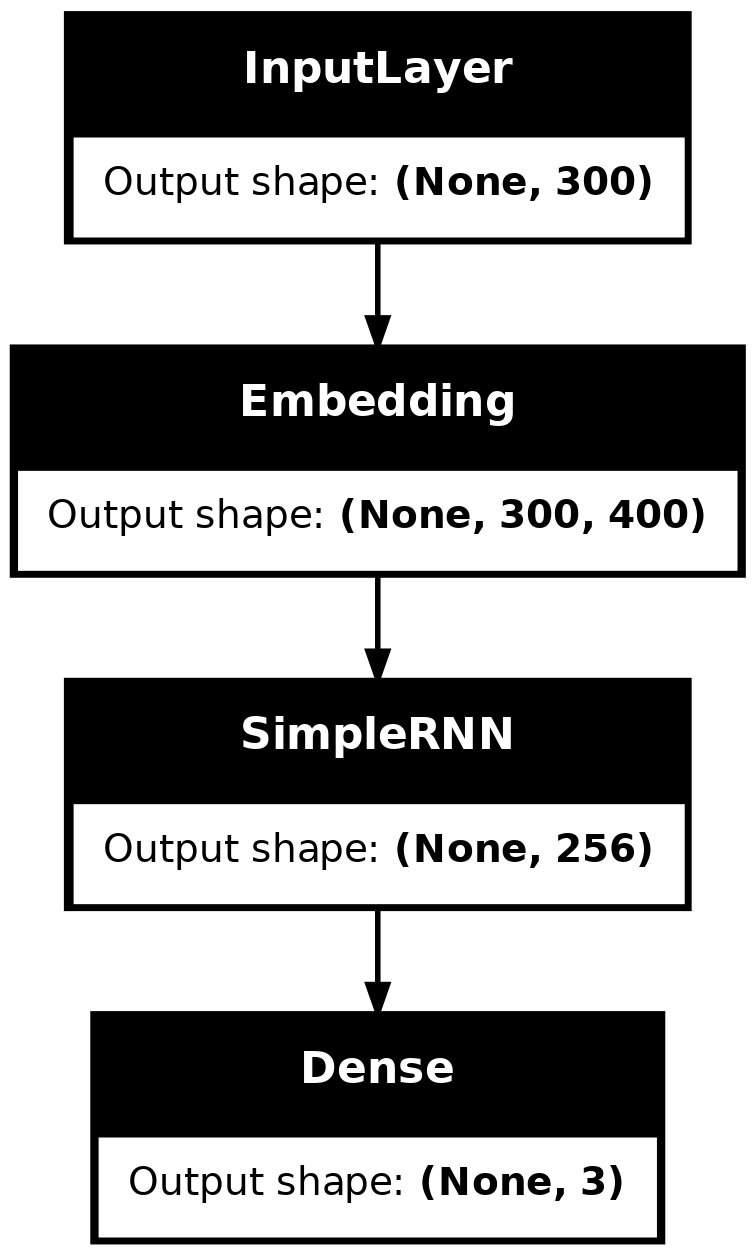

In [13]:
sequence_length = data_train.shape[1]

if os.path.exists('weights/model_rnn.keras'):
    model_rnn = keras.models.load_model('weights/model_rnn.keras')
else:
    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)

    rnn = SimpleRNN(256)(embedding)

    output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(rnn)

    # this creates a model that includes
    model_rnn = Model(inputs, output)

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.001)
    model_rnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model_rnn.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights/model_rnn.keras', verbose=1, save_best_only=True)
callbacks_list = [early_stopping, checkpointer]

model_rnn.fit(data_train, labels_train, validation_split=0.2,
          epochs=20, batch_size=256, callbacks=callbacks_list, shuffle=True)

plot_model(model_rnn, to_file='graph/model_rnn.png', show_shapes=True)

### LTSM Model

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 400)       │     3,167,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       672,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,523,419 (43.96 MB)

 Trainable params: 3,841,139 (14.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,682,280 (29.31 MB)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9849 - loss: 0.1205
Epoch 1: val_loss improved from inf to 4.14770, saving model to weights/model_lstm.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9847 - loss: 0.1207 - val_accuracy: 0.1284 - val_loss: 4.1477
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9913 - loss: 0.1020
Epoch 2: val_loss improved from 4.14770 to 3.36876, saving model to weights/model_lstm.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9913 - loss: 0.1020 - val_accuracy: 0.2225 - val_loss: 3.3688
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9930 - loss: 0.0976
Epoch 3: val_loss improved from 3.36876 to 2.66725, saving model to weights/model_lstm.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9929 - loss: 0.0975 - val_accuracy: 0.3500 - val_loss: 2.6672
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9914 - loss: 0.0927
Epoch 4: val_loss did not improve from 2.66725
1

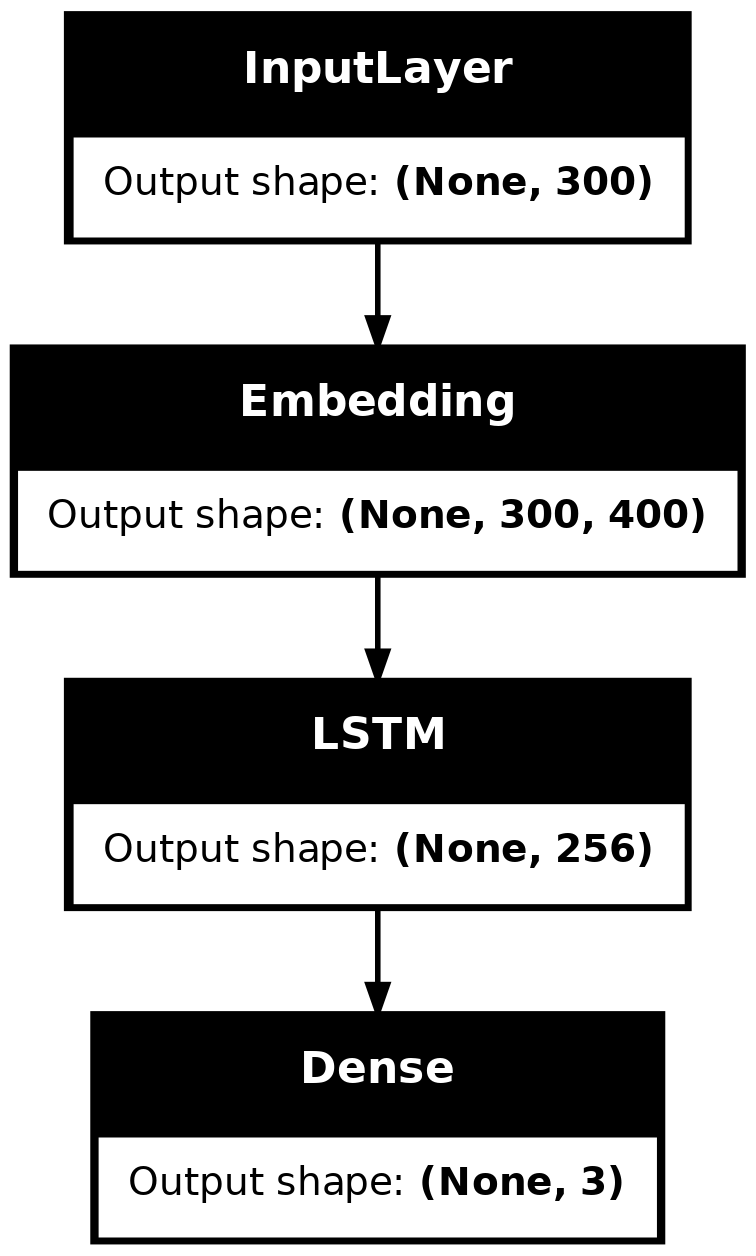

In [46]:
sequence_length = data_train.shape[1]

if os.path.exists('weights/model_lstm.keras'):
    model_cnn = keras.models.load_model('weights/model_lstm.keras')
else:
    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)

    lstm = LSTM(256)(embedding)

    output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(lstm)

    # this creates a model that includes
    model_lstm = Model(inputs, output)

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.001)
    model_lstm.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model_lstm.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights/model_lstm.keras', verbose=1, save_best_only=True)
callbacks_list = [early_stopping, checkpointer]

model_lstm.fit(data_train, labels_train, validation_split=0.2,
          epochs=20, batch_size=256, callbacks=callbacks_list, shuffle=True)

plot_model(model_lstm, to_file='graph/model_lstm.png', show_shapes=True)

### CNN + LSTM Model

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 400)  │  3,167,600 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 298, 100)  │    120,100 │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 297, 100)  │    160,100 │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 296, 100)  │    200,100 │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │     80,400 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 100)       │     80,400 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 100)       │     80,400 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 100)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 100)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 100)    │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3, 100)    │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_1[0][0],  │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 300)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 300)       │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        903 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,890,003 (14.84 MB)

 Trainable params: 3,890,003 (14.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4259 - loss: 5.5061
Epoch 1: val_loss improved from inf to 4.87882, saving model to weights/model_cnn_lstm.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4296 - loss: 5.4725 - val_accuracy: 0.0000e+00 - val_loss: 4.8788
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6485 - loss: 3.2598
Epoch 2: val_loss improved from 4.87882 to 3.19855, saving model to weights/model_cnn_lstm.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6491 - loss: 3.2380 - val_accuracy: 9.8039e-04 - val_loss: 3.1986
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7104 - loss: 1.9244
Epoch 3: val_loss improved from 3.19855 to 2.69275, saving model to weights/model_cnn_lstm.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7108 - loss: 1.9154 - val_accuracy: 0.0422 - val_loss: 2.6928
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7498 - loss: 1.3997
Epoch 4: val_loss improved from 2.69275

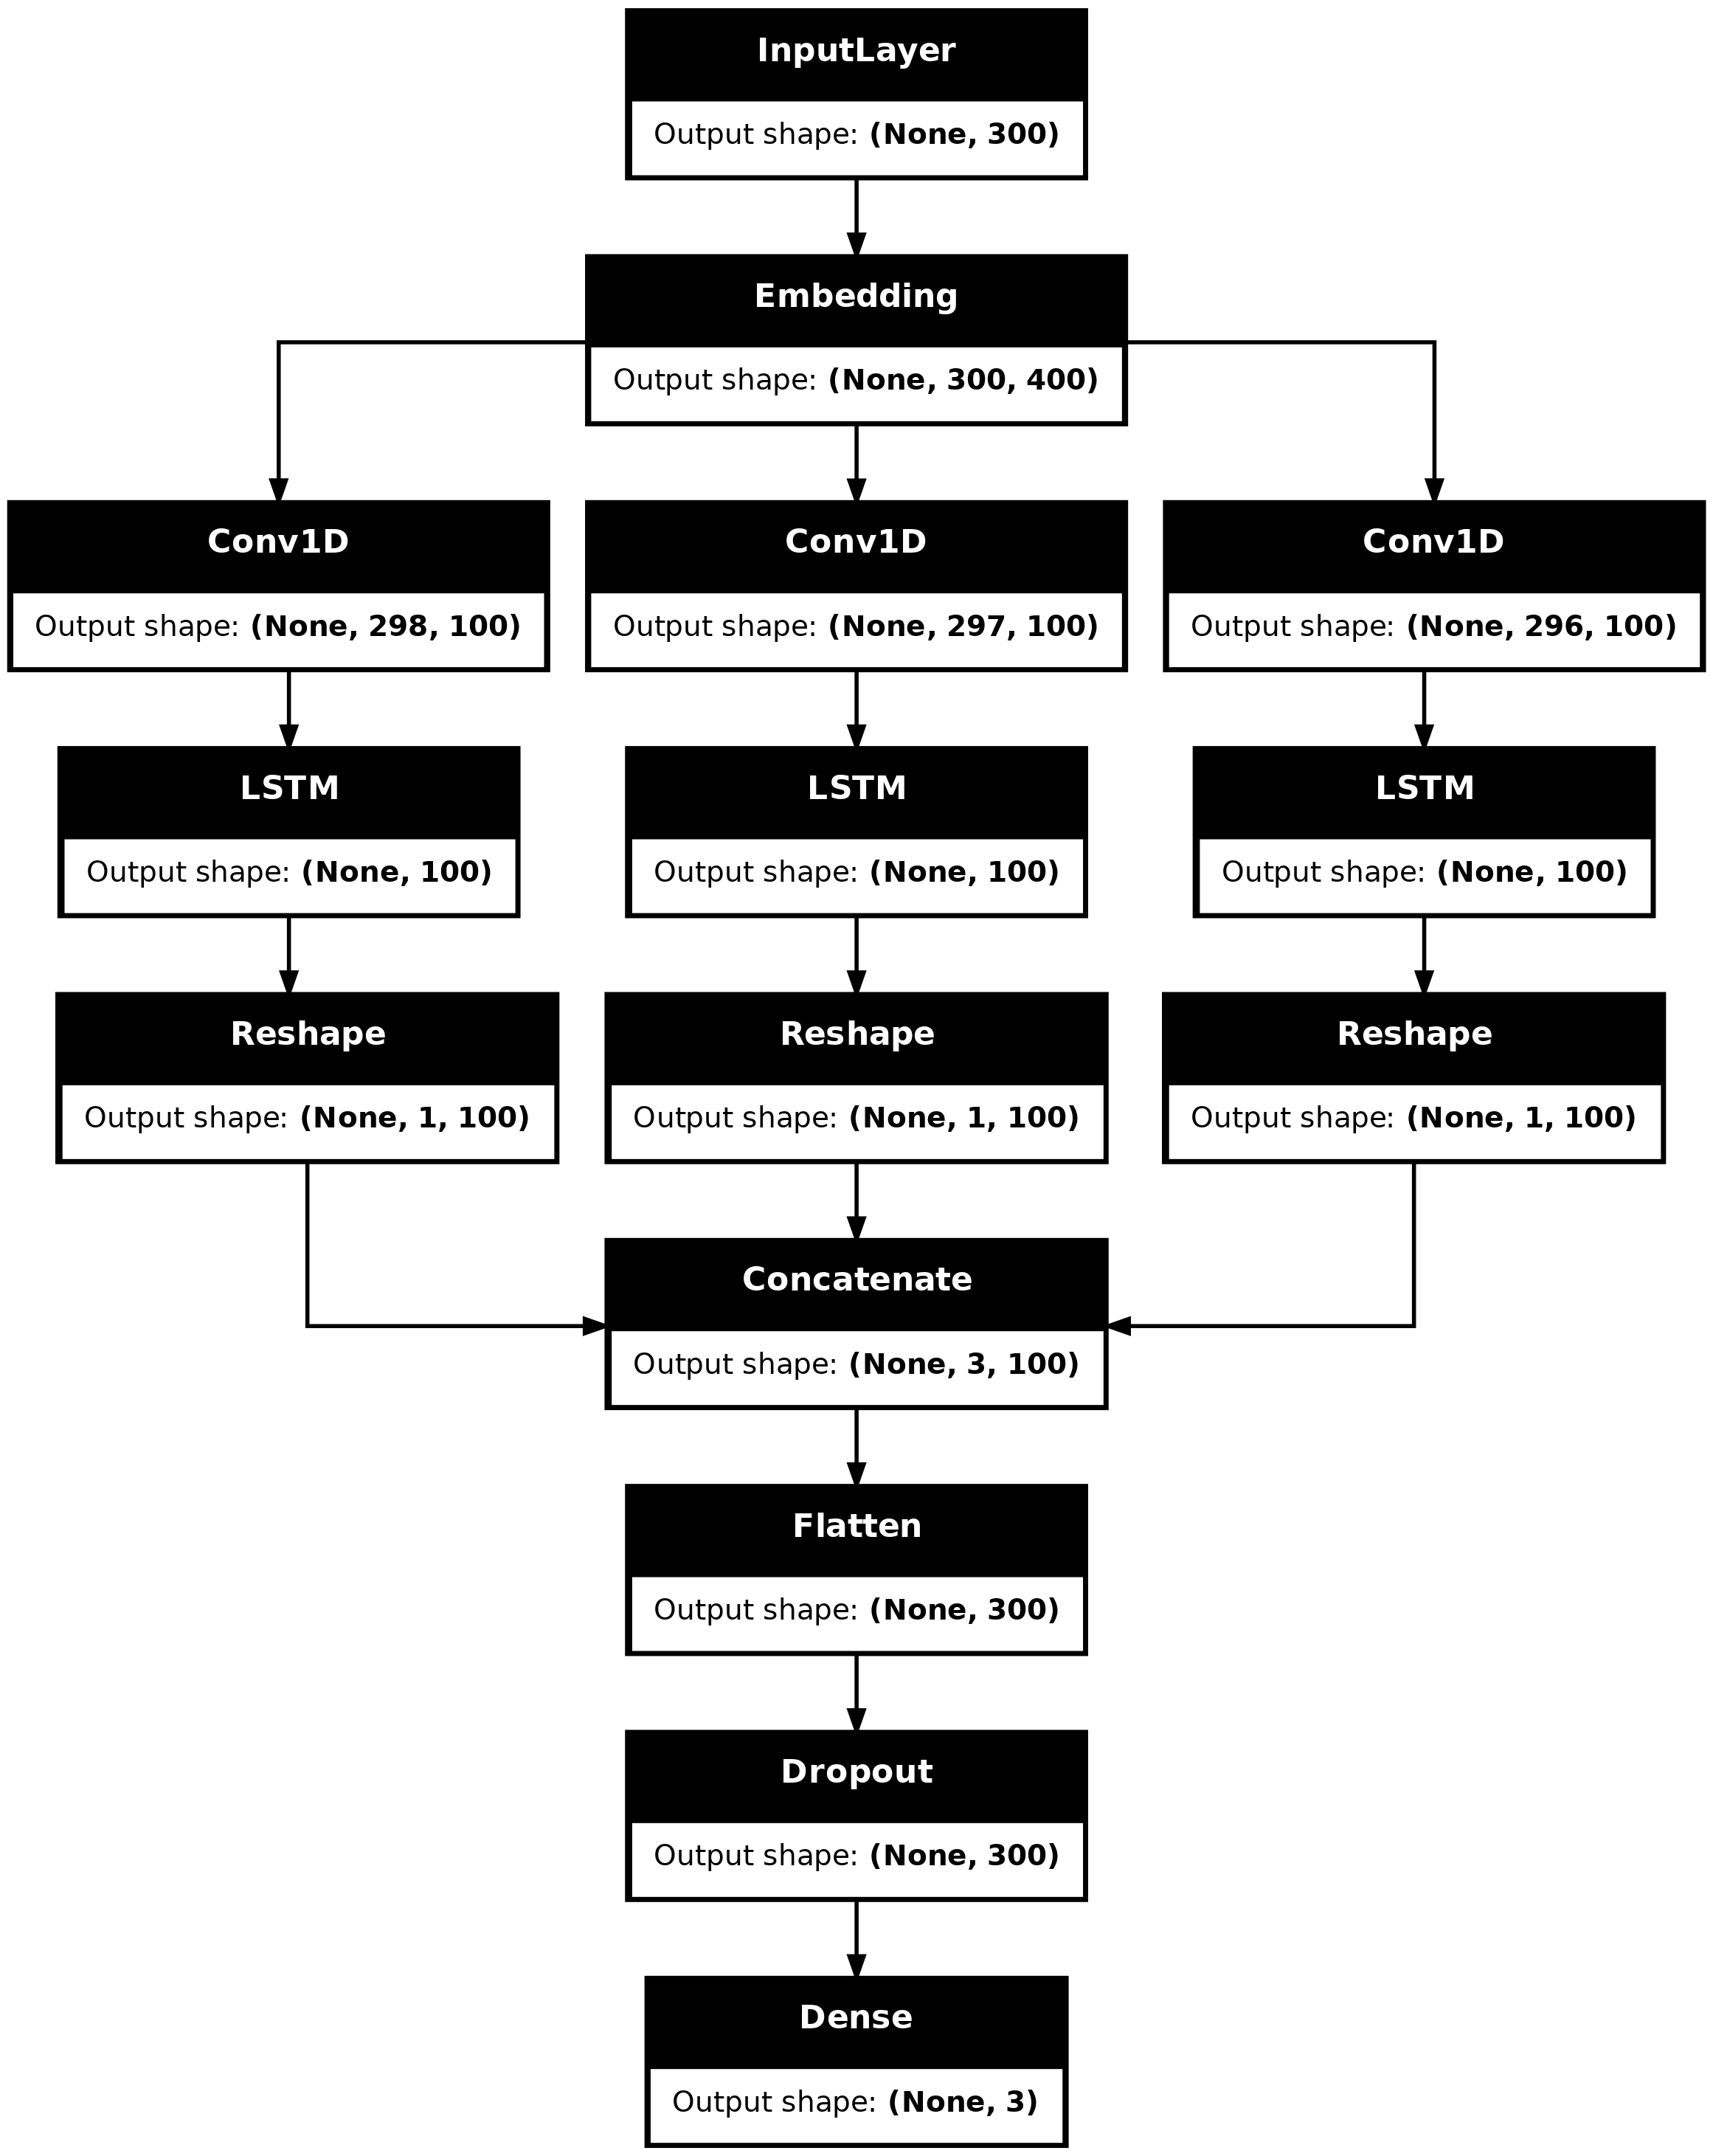

In [15]:
sequence_length = data_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.2

if os.path.exists('weights/model_cnn_lstm.keras'):
    model_cnn = keras.models.load_model('weights/model_cnn_lstm.keras')
else:

    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)

    conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
    conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
    conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

    lstm_0 = LSTM(num_filters)(conv_0)
    lstm_1 = LSTM(num_filters)(conv_1)
    lstm_2 = LSTM(num_filters)(conv_2)

    lstm_0 = Reshape((1,lstm_0.shape[1]))(lstm_0)  
    lstm_1 = Reshape((1,lstm_1.shape[1]))(lstm_1)
    lstm_2 = Reshape((1,lstm_2.shape[1]))(lstm_2)

    merged_tensor = concatenate([lstm_0, lstm_1, lstm_2], axis=1)
    flatten = Flatten()(merged_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

    # this creates a model that includes
    model_cnn_lstm = Model(inputs, output)

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.001)
    model_cnn_lstm.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
model_cnn_lstm.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights/model_cnn_lstm.keras', verbose=1, save_best_only=True)
callbacks_list = [early_stopping, checkpointer]

model_cnn_lstm.fit(data_train, labels_train, validation_split=0.2,
          epochs=20, batch_size=256, callbacks=callbacks_list, shuffle=True)

plot_model(model_cnn_lstm, to_file='graph/model_cnn_lstm.png', show_shapes=True)

### LSTM + CNN Model

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 400)  │  3,167,600 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 300, 256)  │    672,768 │ embedding[4][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 298, 100)  │     76,900 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 297, 100)  │    102,500 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 296, 100)  │    128,100 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1, 100)    │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 1, 100)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 1, 100)    │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3, 100)    │          0 │ max_pooling1d_3[… │
│ (Concatenate)       │                   │            │ max_pooling1d_4[… │
│                     │                   │            │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 300)       │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 300)       │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,148,771 (15.83 MB)

 Trainable params: 4,148,771 (15.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5439 - loss: 4.9965
Epoch 1: val_loss improved from inf to 4.39637, saving model to weights/model_lstm_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5493 - loss: 4.9657 - val_accuracy: 0.2098 - val_loss: 4.3964
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8293 - loss: 2.9847
Epoch 2: val_loss improved from 4.39637 to 3.69616, saving model to weights/model_lstm_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8299 - loss: 2.9666 - val_accuracy: 0.1931 - val_loss: 3.6962
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9032 - loss: 1.7626
Epoch 3: val_loss did not improve from 3.69616
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9032 - loss: 1.7514 - val_accuracy: 0.0941 - val_loss: 4.0606
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9254 - loss: 1.0387
Epoch 4: val_loss did not improve from 3.69616
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step 

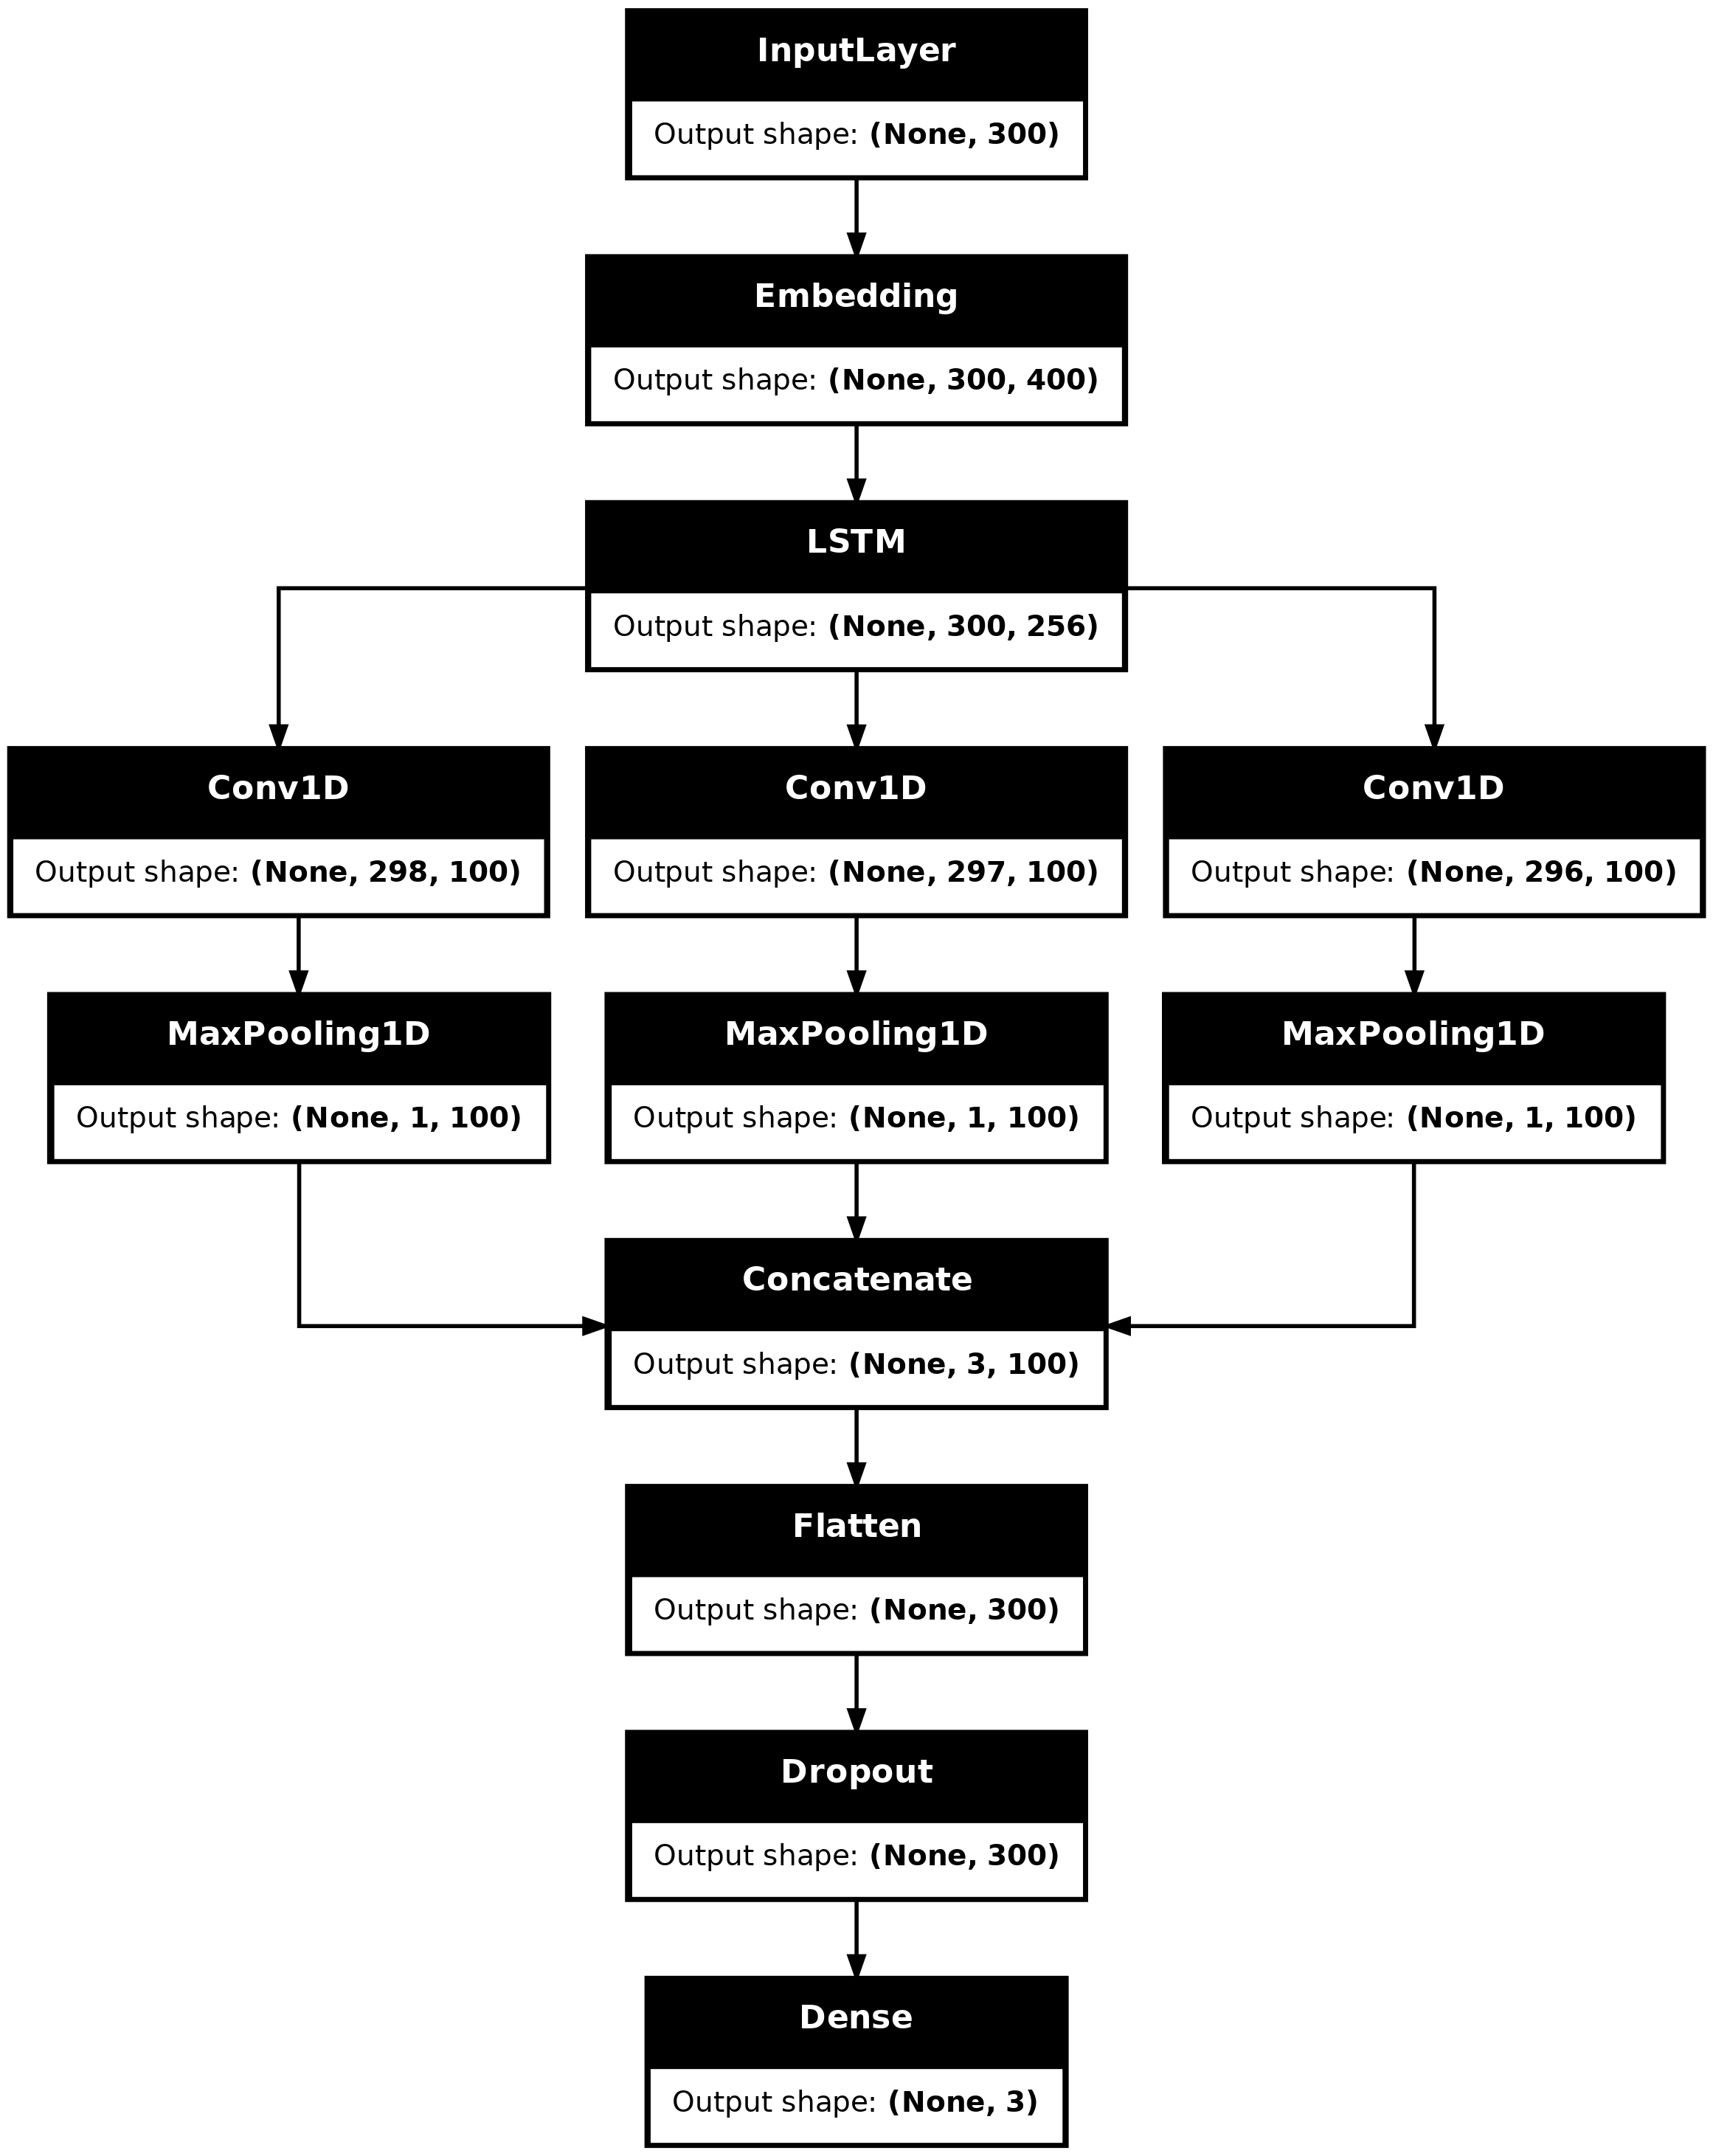

In [16]:
sequence_length = data_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.2

if os.path.exists('weights/model_lstm_cnn.keras'):
    model_cnn = keras.models.load_model('weights/model_lstm_cnn.keras')
else:

    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)

    lstm = LSTM(256,return_sequences= True)(embedding)

    conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(lstm)
    conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(lstm)
    conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(lstm)

    maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
    maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
    maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
    flatten = Flatten()(merged_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

    # this creates a model that includes
    model_lstm_cnn = Model(inputs, output)

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.001)
    model_lstm_cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
model_lstm_cnn.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights/model_lstm_cnn.keras', verbose=1, save_best_only=True)
callbacks_list = [early_stopping, checkpointer]

model_lstm_cnn.fit(data_train, labels_train, validation_split=0.2,
          epochs=20, batch_size=256, callbacks=callbacks_list, shuffle=True)

plot_model(model_lstm_cnn, to_file='graph/model_lstm_cnn.png', show_shapes=True)

### CNN + RNN Model

In [49]:
sequence_length = data_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.2

if os.path.exists('weights/model_cnn_rnn.keras'):
    model_cnn = keras.models.load_model('weights/model_cnn_rnn.keras')
else:
    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)

    conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
    conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
    conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

    rnn_0 = SimpleRNN(num_filters)(conv_0)
    rnn_1 = SimpleRNN(num_filters)(conv_1)
    rnn_2 = SimpleRNN(num_filters)(conv_2)

    rnn_0 = Reshape((1,rnn_0.shape[1]))(rnn_0)  
    rnn_1 = Reshape((1,rnn_1.shape[1]))(rnn_1)
    rnn_2 = Reshape((1,rnn_2.shape[1]))(rnn_2)

    merged_tensor = concatenate([rnn_0, rnn_1, rnn_2], axis=1)
    flatten = Flatten()(merged_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

    # this creates a model that includes
    model_cnn_rnn = Model(inputs, output)

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.001)
    model_cnn_rnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
model_cnn_rnn.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights/model_cnn_rnn.keras', verbose=1, save_best_only=True)
callbacks_list = [early_stopping, checkpointer]

model_cnn_rnn.fit(data_train, labels_train, validation_split=0.2,
          epochs=20, batch_size=256, callbacks=callbacks_list, shuffle=True)

plot_model(model_cnn_rnn, to_file='graph/model_cnn_rnn.png', show_shapes=True)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 400)  │  3,167,600 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 298, 100)  │    120,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 297, 100)  │    160,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 296, 100)  │    200,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, 100)       │     20,100 │ conv1d_9[0][0]    │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, 100)       │     20,100 │ conv1d_10[0][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_3        │ (None, 100)       │     20,100 │ conv1d_11[0][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 100)    │          0 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 100)    │          0 │ simple_rnn_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 100)    │          0 │ simple_rnn_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 3, 100)    │          0 │ reshape_3[0][0],  │
│ (Concatenate)       │                   │            │ reshape_4[0][0],  │
│                     │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 300)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 300)       │          0 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        903 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,127,311 (42.45 MB)

 Trainable params: 3,709,103 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,418,208 (28.30 MB)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9570 - loss: 0.6533
Epoch 1: val_loss improved from inf to 3.43718, saving model to weights/model_cnn_rnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9574 - loss: 0.6521 - val_accuracy: 0.2029 - val_loss: 3.4372
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9921 - loss: 0.5360
Epoch 2: val_loss did not improve from 3.43718
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9921 - loss: 0.5349 - val_accuracy: 0.0784 - val_loss: 4.7623
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9991 - loss: 0.4411
Epoch 3: val_loss did not improve from 3.43718
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9991 - loss: 0.4400 - val_accuracy: 0.1922 - val_loss: 3.5235
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.3612
Epoch 4: val_loss did not improve from 3.43718
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9999 - loss: 0.3603 - val_accuracy: 0

KeyboardInterrupt: 

### RNN + CNN Model

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 400)  │  3,167,600 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_4        │ (None, 300, 256)  │    168,192 │ embedding[6][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 298, 100)  │     76,900 │ simple_rnn_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 297, 100)  │    102,500 │ simple_rnn_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 296, 100)  │    128,100 │ simple_rnn_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1, 100)    │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 1, 100)    │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 1, 100)    │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 3, 100)    │          0 │ max_pooling1d_6[… │
│ (Concatenate)       │                   │            │ max_pooling1d_7[… │
│                     │                   │            │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 300)       │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 300)       │          0 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │        903 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,644,195 (13.90 MB)

 Trainable params: 3,644,195 (13.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3975 - loss: 6.5329
Epoch 1: val_loss improved from inf to 5.88242, saving model to weights/model_rnn_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4033 - loss: 6.4805 - val_accuracy: 0.0863 - val_loss: 5.8824
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7640 - loss: 4.2747
Epoch 2: val_loss improved from 5.88242 to 5.73291, saving model to weights/model_rnn_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7652 - loss: 4.2628 - val_accuracy: 0.1039 - val_loss: 5.7329
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8982 - loss: 3.3598
Epoch 3: val_loss improved from 5.73291 to 5.53592, saving model to weights/model_rnn_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8987 - loss: 3.3505 - val_accuracy: 0.0667 - val_loss: 5.5359
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9535 - loss: 2.6669
Epoch 4: val_loss improved from 5.53592

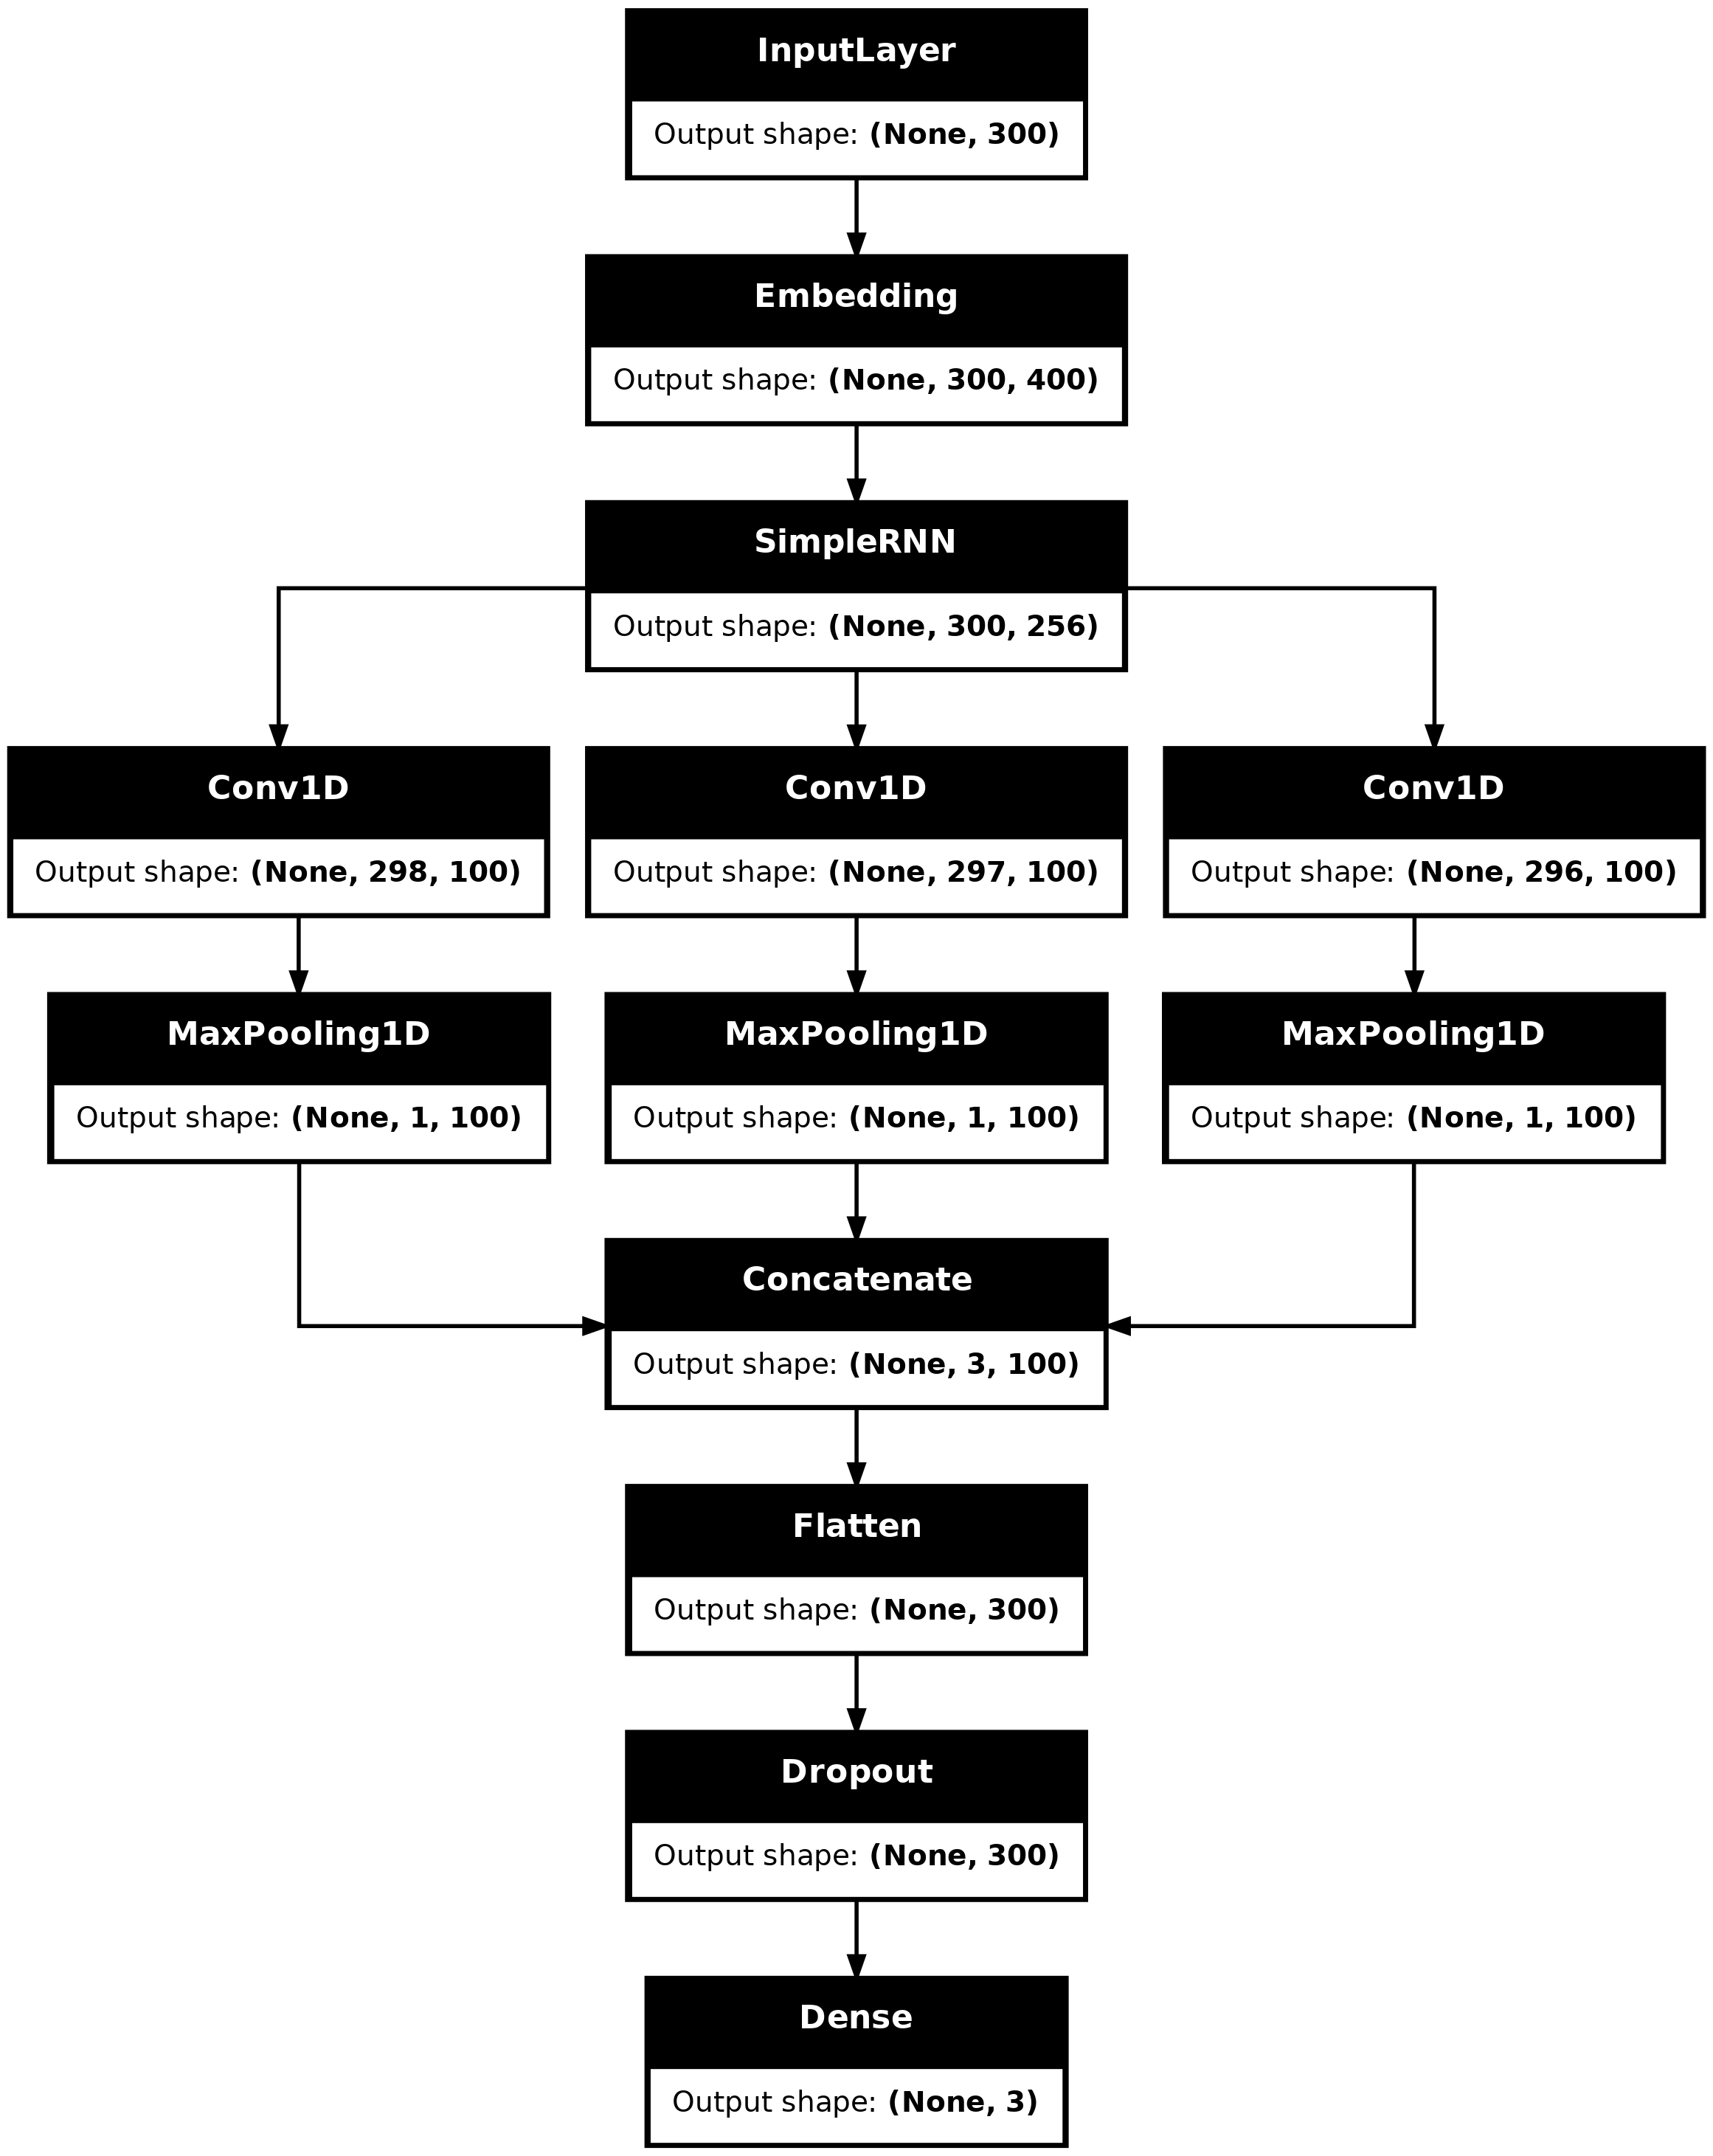

In [18]:
sequence_length = data_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.2


if os.path.exists('weights/model_rnn_cnn.keras'):
    model_cnn = keras.models.load_model('weights/model_rnn_cnn.keras')
else:
    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)

    rnn = SimpleRNN(256,return_sequences= True)(embedding)

    conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(rnn)
    conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(rnn)
    conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(rnn)

    maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
    maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
    maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
    flatten = Flatten()(merged_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

    # this creates a model that includes
    model_rnn_cnn = Model(inputs, output)

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.001)
    model_rnn_cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
model_rnn_cnn.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights/model_rnn_cnn.keras', verbose=1, save_best_only=True)
callbacks_list = [early_stopping, checkpointer]

model_rnn_cnn.fit(data_train, labels_train, validation_split=0.2,
          epochs=20, batch_size=256, callbacks=callbacks_list, shuffle=True)

plot_model(model_rnn_cnn, to_file='graph/model_rnn_cnn.png', show_shapes=True)

### RNN + LSTM + CNN Model

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 400)  │  3,167,600 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_5        │ (None, 300, 256)  │    168,192 │ embedding[7][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 300, 256)  │    525,312 │ simple_rnn_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 298, 100)  │     76,900 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 297, 100)  │    102,500 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 296, 100)  │    128,100 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 1, 100)    │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 1, 100)    │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 1, 100)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 3, 100)    │          0 │ max_pooling1d_9[… │
│ (Concatenate)       │                   │            │ max_pooling1d_10… │
│                     │                   │            │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 300)       │          0 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 300)       │          0 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        903 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,169,507 (15.91 MB)

 Trainable params: 4,169,507 (15.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4254 - loss: 5.2093
Epoch 1: val_loss improved from inf to 5.20023, saving model to weights/model_rnn_lstm_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.4335 - loss: 5.1808 - val_accuracy: 0.1167 - val_loss: 5.2002
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8187 - loss: 3.2786
Epoch 2: val_loss improved from 5.20023 to 4.98275, saving model to weights/model_rnn_lstm_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.8202 - loss: 3.2605 - val_accuracy: 0.1029 - val_loss: 4.9828
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9098 - loss: 2.0499
Epoch 3: val_loss improved from 4.98275 to 4.43484, saving model to weights/model_rnn_lstm_cnn.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9103 - loss: 2.0380 - val_accuracy: 0.1941 - val_loss: 4.4348
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9511 - loss: 1.2569
Epoch 4: val_loss did no

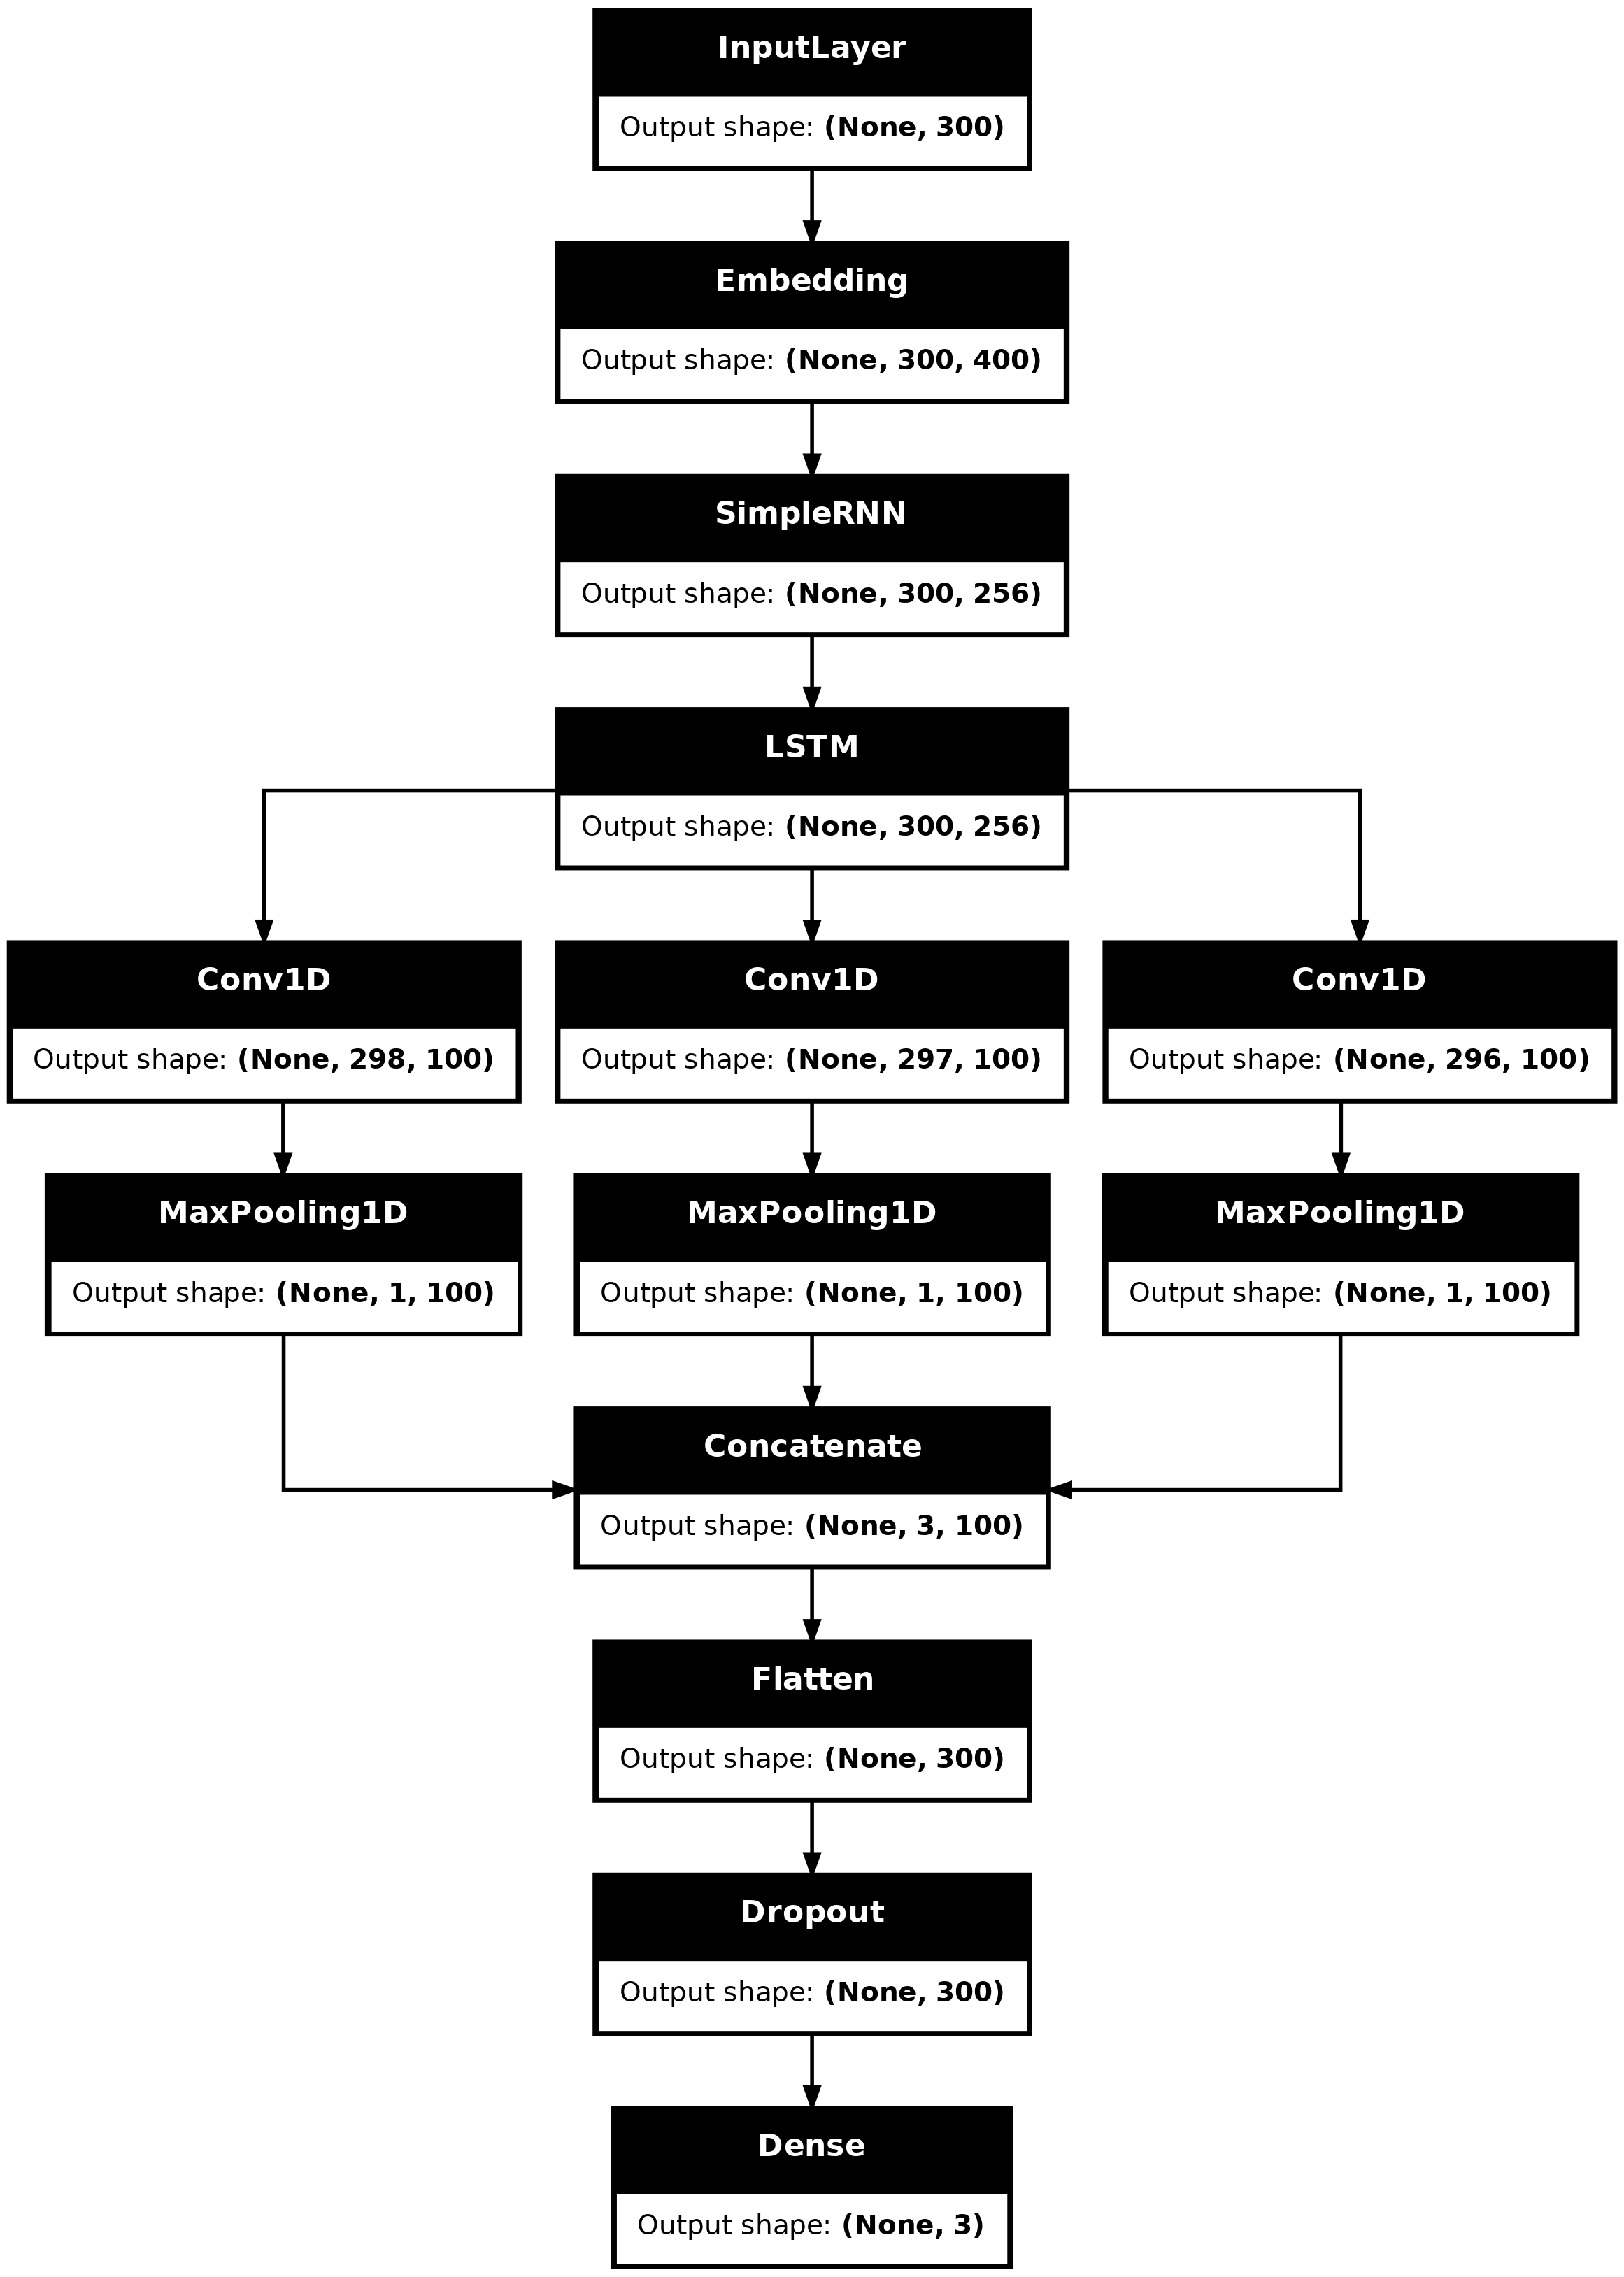

In [19]:
sequence_length = data_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.2

if os.path.exists('weights/model_rnn_lstm_cnn.keras'):
    model_cnn = keras.models.load_model('weights/model_rnn_lstm_cnn.keras')
else:
    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)

    rnn = SimpleRNN(256,return_sequences= True)(embedding)
    lstm = LSTM(256,return_sequences= True)(rnn)

    conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(lstm)
    conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(lstm)
    conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(lstm)

    maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
    maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
    maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
    flatten = Flatten()(merged_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

    # this creates a model that includes
    model_rnn_lstm_cnn = Model(inputs, output)

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.001)
    model_rnn_lstm_cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
model_rnn_lstm_cnn.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights/model_rnn_lstm_cnn.keras', verbose=1, save_best_only=True)
callbacks_list = [early_stopping, checkpointer]

model_rnn_lstm_cnn.fit(data_train, labels_train, validation_split=0.2,
          epochs=20, batch_size=256, callbacks=callbacks_list, shuffle=True)

plot_model(model_rnn_lstm_cnn, to_file='graph/model_rnn_lstm_cnn.png', show_shapes=True)

# VALIDATION

### Preparation

In [20]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [21]:
encoded_labels_test = []

for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test == 0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)  

In [22]:
reviews_processed_test = []
unlabeled_processed_test = [] 
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [23]:
#Use PyVi for Vietnamese word tokenizer
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [24]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [25]:
print('Shape of validation tensor:',data_test.shape)
print('Shape of label validation tensor:', labels_test.shape)

Shape of validation tensor: (1050, 300)
Shape of label validation tensor: (1050, 3)


### CNN Model

In [35]:
model_cnn = keras.models.load_model('weights/model_cnn.keras')
score_cnn = model_cnn.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_cnn.metrics_names[0], score_cnn[0]*100))
print("%s: %.2f%%" % (model_cnn.metrics_names[1], score_cnn[1]*100))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7491 - loss: 1.1496
loss: 144.36%
compile_metrics: 62.86%


### RNN Model

In [36]:
model_rnn = keras.models.load_model('weights/model_rnn.keras')
score_rnn = model_cnn.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_rnn.metrics_names[0], score_rnn[0]*100))
print("%s: %.2f%%" % (model_rnn.metrics_names[1], score_rnn[1]*100))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7491 - loss: 1.1496
loss: 144.36%
compile_metrics: 62.86%


### LSTM Model

In [47]:
model_lstm= keras.models.load_model('weights/model_lstm.keras')
score_lstm = model_lstm.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_lstm.metrics_names[0], score_lstm[0]*100))
print("%s: %.2f%%" % (model_lstm.metrics_names[1], score_lstm[1]*100))

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.6909 - loss: 1.0979
loss: 132.74%
compile_metrics: 64.38%


### CNN + LSTM Model

In [38]:
model_cnn_lstm= keras.models.load_model('weights/model_cnn_lstm.keras')
score_cnn_lstm = model_cnn_lstm.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_cnn_lstm.metrics_names[0], score_cnn_lstm[0]*100))
print("%s: %.2f%%" % (model_cnn_lstm.metrics_names[1], score_cnn_lstm[1]*100))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7228 - loss: 1.0904
loss: 126.81%
compile_metrics: 65.33%


### LSTM + CNN Model

In [39]:
model_lstm_cnn= keras.models.load_model('weights/model_lstm_cnn.keras')
score_lstm_cnn = model_lstm_cnn.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_lstm_cnn.metrics_names[0], score_lstm_cnn[0]*100))
print("%s: %.2f%%" % (model_lstm_cnn.metrics_names[1], score_lstm_cnn[1]*100))

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.7665 - loss: 2.2539
loss: 254.81%
compile_metrics: 63.81%


### CNN + RNN Model

In [40]:
model_cnn_rnn= keras.models.load_model('weights/model_cnn_rnn.keras')
score_cnn_rnn = model_cnn_rnn.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_cnn_rnn.metrics_names[0], score_cnn_rnn[0]*100))
print("%s: %.2f%%" % (model_cnn_rnn.metrics_names[1], score_cnn_rnn[1]*100))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6502 - loss: 1.4634
loss: 199.10%
compile_metrics: 52.19%


### RNN + CNN Model

In [41]:
model_rnn_cnn= keras.models.load_model('weights/model_rnn_cnn.keras')
score_rnn_cnn = model_rnn_cnn.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_rnn_cnn.metrics_names[0], score_rnn_cnn[0]*100))
print("%s: %.2f%%" % (model_rnn_cnn.metrics_names[1], score_rnn_cnn[1]*100))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7767 - loss: 1.2880
loss: 176.60%
compile_metrics: 64.10%


### RNN + LSTM + CNN Model

In [42]:
model_rnn_lstm_cnn= keras.models.load_model('weights/model_rnn_lstm_cnn.keras')
score_rnn_lstm_cnn = model_rnn_lstm_cnn.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_rnn_lstm_cnn.metrics_names[0], score_rnn_lstm_cnn[0]*100))
print("%s: %.2f%%" % (model_rnn_lstm_cnn.metrics_names[1], score_rnn_lstm_cnn[1]*100))

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.7274 - loss: 1.4325
loss: 183.04%
compile_metrics: 63.33%


### COMPARE MODEL RESULT

In [48]:
# initialize list of lists
data = [['CNN', score_cnn[0]*100, score_cnn[1]*100],
        ['RNN', score_rnn[0]*100, score_rnn[1]*100],
        ['LSTM', score_lstm[0]*100, score_lstm[1]*100],
        ['CNN_RNN', score_cnn_rnn[0]*100, score_cnn_rnn[1]*100],
        ['RNN_CNN', score_rnn_cnn[0]*100, score_rnn_cnn[1]*100],
        ['CNN_LSTM', score_cnn_lstm[0]*100, score_cnn_lstm[1]*100],
        ['LSTM_CNN', score_lstm_cnn[0]*100, score_lstm_cnn[1]*100],
        ['RNN_LSTM_CNN', score_rnn_lstm_cnn[0]*100, score_rnn_lstm_cnn[1]*100]]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Models', 'Loss', 'Accuracy'])


# print dataframe
df

,Models,Loss,Accuracy
0,CNN,144.360256,62.857145
1,RNN,144.360256,62.857145
2,LSTM,132.736635,64.380950
3,CNN_RNN,199.099267,52.190477
4,RNN_CNN,176.597619,64.095241
5,CNN_LSTM,126.814222,65.333331
6,LSTM_CNN,254.805350,63.809526
7,RNN_LSTM_CNN,183.038116,63.333333
